In [1]:
from utils import QuantumDotFET

from diamondminer.utils import *
from diamondminer.miner import * 

Detectron2 not found on the system cannot run any segmentation models.


# Connect to Tuner Class

In [2]:
QD_FET_Tuner = QuantumDotFET(
    config='config-files/config.yaml',
    tuner_config='config-files/fet_tuner_config.yaml',
    station_config='config-files/station_config.yaml',
    save_dir='C:\\Users\\coher\\Desktop\\Ben Van Osch\\Intel_Tunnel_Falls_3D1S_3\\Autotuning Data'
)

2025-07-07 14:52:11,541 - utils - ATTEMPT connecting to station
Connected to: Stanford_Research_Systems SIM900 (serial:s/n130900, firmware:ver3.6) in 1.73s
Connected to: HEWLETT-PACKARD 34401A (serial:0, firmware:11-5-3) in 0.07s
2025-07-07 14:52:15,604 - utils - COMPLETE 

2025-07-07 14:52:15,614 - utils - IN PROGRESS changing parameters to match names in config.yaml file
2025-07-07 14:52:15,624 - utils - IN PROGRESS changed volt_2 to CG0b
2025-07-07 14:52:15,624 - utils - IN PROGRESS changed volt_3 to F1
2025-07-07 14:52:15,636 - utils - IN PROGRESS changed volt_4 to S3
2025-07-07 14:52:15,645 - utils - IN PROGRESS changed volt_5 to AC3
2025-07-07 14:52:15,645 - utils - IN PROGRESS changed volt_6 to AC2
2025-07-07 14:52:15,651 - utils - IN PROGRESS changed volt_7 to B20
2025-07-07 14:52:15,655 - utils - IN PROGRESS changed volt_8 to B21
2025-07-07 14:52:15,655 - utils - IN PROGRESS changed volt_1 to P20
2025-07-07 14:52:15,696 - utils - IN PROGRESS database created/loaded @ C:\Users\

Optional: Monitoring your variables

In [ ]:
# !python -m qcodes.monitor.monitor
# monitor = qc.Monitor(
#     QD_FET_Tuner.drain_volt, 
#     QD_FET_Tuner.voltage_source.S, 
#     QD_FET_Tuner.voltage_source.L,
#     QD_FET_Tuner.voltage_source.LB,
#     QD_FET_Tuner.voltage_source.P,
#     QD_FET_Tuner.voltage_source.RB,
#     )
# monitor.show()

In [3]:
QD_FET_Tuner.ground_device()

2025-07-07 14:52:18,578 - utils - ATTEMPT grounding device
2025-07-07 14:52:33,157 - utils - COMPLETE 



# 0. Bias Device 

In [4]:
QD_FET_Tuner.bias_ohmic(
    ohmic='S3', 
    V=-0.03,
) 

2025-07-07 10:16:13,427 - utils - ATTEMPT setting ohmic (S3) to -0.03 V
2025-07-07 10:16:13,427 - utils - IN PROGRESS device receives -0.3 mV based on divider
2025-07-07 10:16:13,727 - utils - COMPLETE 



# 1. Turn On Device

2025-07-07 10:19:26,096 - utils - IN PROGRESS setting ['B20', 'B21', 'F1', 'AC3', 'AC2', 'P20'] to 0 V
2025-07-07 10:19:40,473 - utils - ATTEMPT sweeping ['B20', 'B21', 'F1', 'AC3', 'AC2', 'P20'] together from 0 V to 1.7 V
Starting experimental run with id: 2. Using 'qcodes.dataset.dond'


  0%|          | 0/851 [00:00<?, ?it/s]

2025-07-07 10:21:54,004 - utils - COMPLETE 

2025-07-07 10:21:56,909 - utils - ERROR fitting to "logarithmic" failed
Did the device actually turn-on? [y/N] 

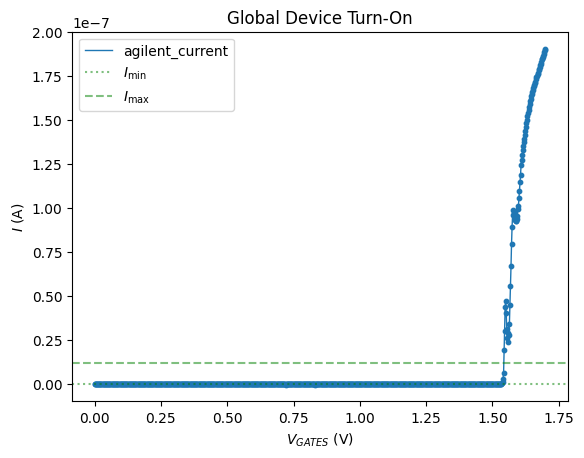

In [3]:
turn_on_data = QD_FET_Tuner.turn_on(
    minV=0, 
    maxV=1.7,
    dV=0.002
)

# 2. Pinch Off Gate(s)

In [3]:
QD_FET_Tuner.deviceTurnsOn=True

QD_FET_Tuner.results['turn_on']['voltage'] = 1.6
QD_FET_Tuner.results['turn_on']['saturation'] = 1.7


2025-07-07 10:22:16,990 - utils - IN PROGRESS setting voltage configuration: {'AC2': 1.5, 'AC3': 1.5, 'F1': 1.5, 'P20': 1.5}
2025-07-07 10:22:18,901 - utils - IN PROGRESS setting ['B20', 'B21'] to 1.7 V
2025-07-07 10:22:19,217 - utils - ATTEMPT pinching off B20 from 1.7 V to 0.6 V
Starting experimental run with id: 3. Using 'qcodes.dataset.dond'


  0%|          | 0/221 [00:00<?, ?it/s]

2025-07-07 10:22:34,796 - utils - COMPLETE 

2025-07-07 10:22:34,798 - utils - IN PROGRESS returning B20 to 1.7 V
2025-07-07 10:22:41,239 - utils - IN PROGRESS B20, fitting data to sigmoid
2025-07-07 10:22:41,289 - utils - IN PROGRESS Fit params: a = 1.1765609362421978e-07, b = -34.457866623804236, x0 = 1.611004245591441, y0 = -8.17102077765121e-11
2025-07-07 10:22:41,292 - utils - IN PROGRESS B20, pinch off at 1.529
2025-07-07 10:22:41,292 - utils - IN PROGRESS B20, pinch off width of 0.16
2025-07-07 10:22:41,475 - utils - ATTEMPT pinching off B21 from 1.7 V to 0.6 V
Starting experimental run with id: 4. Using 'qcodes.dataset.dond'


  0%|          | 0/221 [00:00<?, ?it/s]

2025-07-07 10:22:57,506 - utils - COMPLETE 

2025-07-07 10:22:57,513 - utils - IN PROGRESS returning B21 to 1.7 V
2025-07-07 10:23:04,026 - utils - IN PROGRESS B21, fitting data to sigmoid
2025-07-07 10:23:04,091 - utils - IN PROGRESS Fit params: a = 9.893801785433145e-08, b = -30.831976300994135, x0 = 1.4738981709750794, y0 = -4.5766130296689037e-10
2025-07-07 10:23:04,101 - utils - IN PROGRESS B21, pinch off at 1.382
2025-07-07 10:23:04,101 - utils - IN PROGRESS B21, pinch off width of 0.18


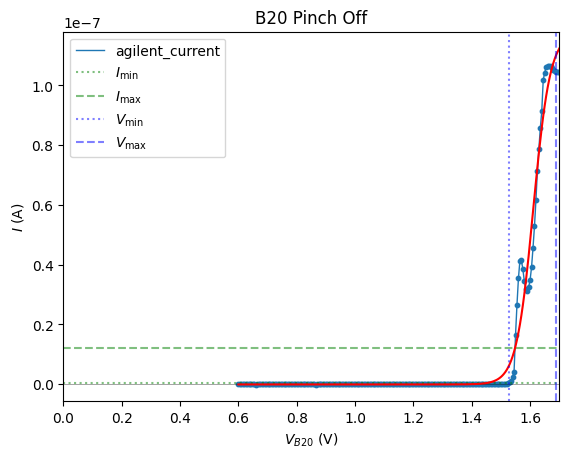

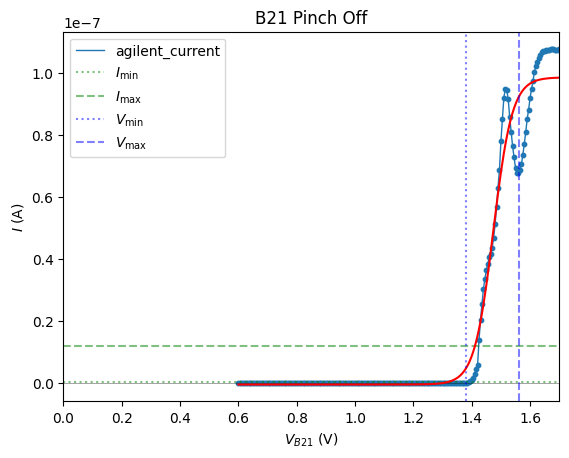

In [4]:
pinch_off_data = QD_FET_Tuner.pinch_off(
    gates=["B20", "B21"],
    minV=0.6, 
    maxV=1.7, 
    dV=0.005,
    voltage_configuration = {"AC2": 1.5,
                             "AC3": 1.5,
                             "F1": 1.5,
                             "P20": 1.5,
                            },
)

In [ ]:
# QD_FET_Tuner.results['LB']['pinch_off']['voltage'] = -2
# QD_FET_Tuner.results['LB']['pinch_off']['width'] = 0.5
# QD_FET_Tuner.results['RB']['pinch_off']['voltage'] = -2
# QD_FET_Tuner.results['RB']['pinch_off']['width'] = 0.5

# 3. Barrier Barrier Sweep

In [ ]:
df, current_axes = QD_FET_Tuner.sweep_barriers(
    B1='B20', 
    B2='B21', 
    B1_bounds=(1.4, 1.7),
    B2_bounds=(1.3, 1.7),
    dV=0.003,
    voltage_configuration = {"AC2": 1.35,
                             "AC3": 1.4,
                             "F1": 1.35,
                             "P20": 1.5,
                            },
    extract_bias_point=False
)

Extract Bias Point 

In [ ]:
db_file =  "c:\\Users\\coher\\Desktop\\noise1\\noise2\\n45_d13_2024-09-25\\experiments_n45_d13_2024-09-25.db"

LB_data, RB_data, I_data = get_data_from_qcodes_db(
    db_file,
    4,
    plot=True
)

extract_bias_point(
    LB_data,
    RB_data,
    I_data * QD_FET_Tuner.preamp_sensitivity,
    minAngleDeg = -60,
    maxAngleDeg = -40,
    threshold=10,
    minLineLength = 50,
    maxLineGap=250,
    debug=False,
    plot_results=True
)

In [ ]:
bias_point = {'LB': 0.675, 'RB': 0.75}

# Coulomb Blockade

In [ ]:
df, axes = QD_FET_Tuner.coulomb_blockade(
    gate='P', 
    gate_bounds=(0.5, -0.5), 
    dV=0.005,
    voltage_configuration = bias_point, 
)

Extract $\underset{\tilde{V}_P}{\mathrm{argmax}}\ G_{SD}$

In [ ]:
# QD_FET_Tuner.bias_ohmic(ohmic="S", V=0.01)
# print(QD_FET_Tuner._get_drain_current())

In [ ]:
results = QD_FET_Tuner.extract_max_conductance_point(
    df,
    plot_process=True,
    sigma=0.5
)
for key, value in results.items():
    print(f"{key}: {value}")

# 5. Coulomb Diamonds

In [ ]:
QD_FET_Tuner.bias_ohmic(ohmic="S", V=0.01)

In [ ]:
df, cd_axes = QD_FET_Tuner.coulomb_diamonds(
    ohmic='S', 
    gate='P', 
    ohmic_bounds=(-0.5,0.5), #V
    gate_bounds=(0.2,-0.35), #V
    delay=0.1,
    dV_gate=0.002, 
    dV_ohmic=0.002,
    voltage_configuration=bias_point,
)

Extract lever arm, $\alpha$, at $\tilde{V}_{P}$

In [ ]:
P_data, S_data, I_data = get_data_from_qcodes_db(
    db_file,
    7,
    plot=True
)

In [ ]:
crop_left = 100
crop_right = -70

miner = Miner(
    gate_data=P_data[crop_left:crop_right],
    ohmic_data=S_data[:] * 1e-2,
    current_data=I_data[:, crop_left:crop_right] * 1e-8,
    epsR = 3.9,
    oxide_thickness=10e-9,
    binary_threshold=1.15,
    blur_sigma=3.,
    blur_kernel=(3,3)

)
diamond = miner.extract_diamonds(debug=True)

In [ ]:
miner.plot_diamonds()

In [ ]:
statistics = miner.get_statistics()

# Current Trace

In [ ]:
QD_FET_Tuner.drain_mm_device.NPLC(1)
QD_FET_Tuner._smoothly_set_voltage_configuration({"P": -0.1}) # HIGH
# QD_FET_Tuner._smoothly_set_voltage_configuration({"P": -0.42}) #LOW
# QD_FET_Tuner._smoothly_set_voltage_configuration({"P": -0.26}) #CB

In [ ]:
df = QD_FET_Tuner.current_trace(
    f_sampling=20, #Hz
    t_capture=100, #s 
    plot_psd=True,
    meas_name="zero_current",
    # voltage_configuration={"P":0.1}
)

In [ ]:
db_file =  "c:\\Users\\coher\\Desktop\\noise1\\n45_d13_2024-09-25\\experiments_n45_d13_2024-09-25.db"


qc.dataset.initialise_or_create_database_at(db_file)
# tutorial_exp = qc.dataset.load_or_create_experiment(
#     experiment_name="Initialization",
#     sample_name="n45_d13"
# )

dataset = qc.dataset.load_by_run_spec(experiment_name='Initialization', captured_run_id=12)
qc.dataset.plot_dataset(dataset)


In [ ]:
print(len(df))

# Ground Device

In [ ]:
QD_FET_Tuner.ground_device()

# DATABASE VIEWER

In [ ]:
db_file = "c:\\Users\\coher\\Desktop\\noise1\\noise2\\n45_d13_2024-09-25\\experiments_n45_d13_2024-09-25.db"
import IPython.lib.backgroundjobs as bg
from plottr.apps import inspectr

jobs = bg.BackgroundJobManager()
jobs.new(inspectr.main, db_file)

In [ ]:
db_file = "c:\\Users\\coher\\Desktop\\noise1\\noise2\\n45_d13_2024-09-25\\experiments_n45_d13_2024-09-25.db"

import qcodes as qc
import sys, os
import matplotlib.pyplot as plt

qc.dataset.initialise_or_create_database_at(db_file)

dataset = qc.dataset.load_by_run_spec(experiment_name='Initialization', captured_run_id=10)
qc.dataset.plot_dataset(dataset)
df = dataset.to_pandas_dataframe().reset_index()

In [ ]:
print(df)

In [ ]:
# import skimage
# from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
# from skimage.feature import canny
# from skimage.draw import line as draw_line
# from skimage import data
# import matplotlib.cm as cm


# range_RB = (0.615,0.747)
# range_LB = (0.533,0.631)
# filtered_df = df[
#     (df['sim900_volt_RB'] >= range_RB[0]) & (df['sim900_volt_RB'] <= range_RB[1]) &
#     (df['sim900_volt_LB'] >= range_LB[0]) & (df['sim900_volt_LB'] <= range_LB[1])
# ]

# cropped_img, Xdata, Ydata = convert_data_to_image(filtered_df)
# cropped_img = cropped_img[:,:,0]
# edges = canny(cropped_img,sigma=0.5, low_threshold=0.1*np.iinfo(np.uint8).max, high_threshold=0.3 * np.iinfo(np.uint8).max)
# lines = probabilistic_hough_line(edges, threshold=0, line_length=3,
#                                  line_gap=0)
# # Generating figure 2
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# ax = axes.ravel()

# ax[0].imshow(cropped_img, cmap=cm.gray, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],)
# ax[0].set_title('Input image')

# ax[1].imshow(edges, cmap=cm.gray, origin='lower',  extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],)
# ax[1].set_title('Masked Canny edges')

# potential_points = {}
# angles_data = []
# slopes_data = []
# for line in lines:
#     p0_pixel, p1_pixel = line
#     p0, p1 = pixel_polygon_to_image_units(line, filtered_df)

#     dy =  (p1[1]-p0[1])
#     dx = (p1[0]-p0[0])
#     if dx == 0:
#         continue
#     m = dy/dx
#     theta = np.arctan(m)*(180/np.pi)
#     if theta > -40 or theta < -60:
#         continue
#     angles_data.append(theta)
#     slopes_data.append(m)
#     midpoint_pixel = (np.array(p0_pixel) + np.array(p1_pixel))/2
#     midpoint_units = (np.array(p0) + np.array(p1))/2
#     # print(midpoint)
#     midpoint = midpoint.astype(int)
#     current_at_midpoint = filtered_df['agilent_volt'].to_numpy().reshape(len(Xdata), len(Ydata))[midpoint[0],midpoint[1]]
#     potential_points[tuple(midpoint_units)] = current_at_midpoint

#     ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
#     ax[1].scatter([midpoint_units[0]],[midpoint_units[1]], marker='*',s=50)
#     ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
#     ax[0].scatter([midpoint_units[0]],[midpoint_units[1]], marker='*',s=50)
    
# # ax[1].set_xlim((0, cropped_img.shape[1]))
# # ax[1].set_ylim((cropped_img.shape[0], 0))
# ax[1].set_title('Probabilistic Hough')
# ax[2].hist(angles_data, bins=2*int(np.sqrt(len(slopes_data))))
# ax[2].set_xlabel(r"$\theta^\circ$")
# ax[2].set_ylabel(r"$f$")
# # ax[2].hist(angles_data)
# # ax[0].set_axis_off()
# ax[1].set_axis_off()

In [ ]:
# print(potential_points)
# max_key = np.array(max(potential_points, key=potential_points.get))
# print("Key with the highest value:", max_key)
# bias_point = {Xdata.name: max_key[0], Ydata.name: max_key[1]}
# I = filtered_df['agilent_volt'].to_numpy().reshape(len(Ydata), len(Xdata))
# plt.imshow(I, extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],origin='lower')
# plt.scatter(*max_key, marker='*', c='r')
# plt.ylabel(Ydata.name)
# plt.xlabel(Xdata.name)
# plt.colorbar()
# plt.show()


# print(f"Bias point: {bias_point}")